<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=150 HEIGHT=100>

<CENTER>
</br>
<p><font size="5"> Speaker Diarization </span></p>
<p><font size="3">  UE Recherche  </font></p>
<p></p>
<p><font size="4"> Emmanuel Leguet - Hubert Dellon </font></p>
</p></br>
</p>
</CENTER>

### Initialization

In [21]:
# Imports
from vosk import Model, KaldiRecognizer, SpkModel, SetLogLevel
SetLogLevel(-1) # The higher the more vosk logs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import wave
import json
import os
os.chdir('./')

In [22]:
# Get audio
audio = wave.open("Audio/Clement1_5min_extract.wav")

# Get model & speaker model
model = Model("Model")
spk_model = SpkModel("vosk-model-spk-0.4")
vectorSize = 128 # Depends on the spk_model

In [23]:
# Audio parameters
frameRate = audio.getframerate()
nFrame = audio.getnframes()
bufferSize = frameRate // 4
totalTime = nFrame / frameRate

# Times the speaker changes in the selected audio
refTimeSpkChange = [4.94, 5.22, 9.55, 12.35, 20.1, 21.02, 34.09, 35.35, 37.84, 39.5, 49.08, 51.04, 57.02, 58.52, 67.66, 121.63, 123.68, 144.68, 145.5, 150.25, 154.52, 155.49, 155.8, 171.01, 173.85, 178.85, 183.66, 184.36, 189.49, 237.02, 241.68, 295.14] 

In [24]:
# Simple word recognition
audio.rewind()

rec = KaldiRecognizer(model, frameRate)
while True:
    data = audio.readframes(bufferSize)
    if len(data) == 0:
        break
    rec.AcceptWaveform(data)

finalResults = json.loads(rec.FinalResult())
wordResult = finalResults['result'] # Words with 'start' and 'end' times

### Functions for diarization
#### Method 0 : Group of words chosen by Vosk ('complete utterance')


In [25]:
def cutVosk(model, spk_model, audio, frameRate, bufferSize):
    spkVectors = []
    resWords = []

    audio.rewind()
    rec = KaldiRecognizer(model, spk_model, frameRate)

    while True:
        data = audio.readframes(bufferSize)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data): # if complete utterance for vosk
            res = json.loads(rec.Result())
            if res['text'] != "":
                spkVectors.append(res['spk'])
                resWords.append(res['result'])

    res = json.loads(rec.FinalResult())
    if res['text'] != "":
        spkVectors.append(res['spk'])
        resWords.append(res['result'])

    return spkVectors, resWords

#### Method 1 : Group of (minimum) minWord words : \[deb_word_1 : end_word_3\]

In [26]:
def cutGroupWords(model, spk_model, audio, frameRate, bufferSize, Words, minGroupWords, shift=0, minTime=0.2):
    spkVectors = []
    groupWords = []
    indW = shift
    bufferWords = []

    while True:
        # Increment the buffer of words
        if bufferWords == []:
            if indW == len(Words):
                break
            else:
                maxBuffer = min(minGroupWords, len(Words)-indW)
                for i in range(maxBuffer):
                    bufferWords.append(Words[indW])
                    indW += 1
        elif indW == len(Words):
            spkVectors.append(spkVectors[-1])
            groupWords.append(len(bufferWords))
            break
        else:
            bufferWords.append(Words[indW])
            indW += 1
        
        startTime = bufferWords[0]['start']
        stopTime = bufferWords[-1]['end']

        if stopTime - startTime >= minTime:
            # Calculate the frames 
            nFrame = int(np.ceil((stopTime - startTime) * frameRate))
            nCompleteFrames = nFrame // bufferSize
            nRestFrames = nFrame % bufferSize

            startFrame = int(np.floor(startTime * frameRate))
            audio.setpos(startFrame)
            bufferFrames = [audio.readframes(bufferSize) for i in range(nCompleteFrames)] + [audio.readframes(nRestFrames)]
            
            # Calculate a vector on the frames
            rec = KaldiRecognizer(model, spk_model, frameRate)
            for buffer in bufferFrames:
                rec.AcceptWaveform(buffer)
            res = json.loads(rec.FinalResult())
            spkVectors.append(res['spk'])

            # Reinitialize the buffer of words
            groupWords.append(len(bufferWords))
            bufferWords = []

    return spkVectors, groupWords

#### Method 2 : Group of (minimum) minWord words : \[deb_word_1:end_word_1,..., deb_word_3:end_word_3\]

In [27]:
def cutGroupJustWords(model, spk_model, audio, frameRate, bufferSize, Words, minGroupWords, shift=0, minTime=0.2):
    spkVectors = []
    groupWords = []
    indW = shift
    bufferWords = []

    while True:
        # Increment the buffer of words
        if bufferWords == []:
            if indW == len(Words):
                break
            else:
                maxBuffer = min(minGroupWords, len(Words)-indW)
                for i in range(maxBuffer):
                    bufferWords.append(Words[indW])
                    indW += 1
        elif indW == len(Words):
            spkVectors.append(spkVectors[-1])
            groupWords.append(len(bufferWords))
            break
        else:
            bufferWords.append(Words[indW])
            indW += 1
        
        startTime = bufferWords[0]['start']
        stopTime = bufferWords[-1]['end']

        if stopTime - startTime >= minTime:
            # Calculate the frames 
            totalTime = 0
            bufferFrames = []
            for word in bufferWords:
                startTime = word['start']
                stopTime = word['end']
                totalTime += stopTime - startTime

                nFrame = int(np.ceil((stopTime - startTime) * frameRate))
                nCompleteFrames = nFrame // bufferSize
                nRestFrames = nFrame % bufferSize

                startFrame = int(np.floor(startTime * frameRate))
                audio.setpos(startFrame)
                bufferFrames += [audio.readframes(bufferSize) for i in range(nCompleteFrames)] + [audio.readframes(nRestFrames)]

            # Calculate a vector on the frames
            rec = KaldiRecognizer(model, spk_model, frameRate)
            for buffer in bufferFrames:
                rec.AcceptWaveform(buffer)
            res = json.loads(rec.FinalResult())
            spkVectors.append(res['spk'])

            # Reinitialize the buffer of words
            groupWords.append(len(bufferWords))
            bufferWords = []

    return spkVectors, groupWords

#### Method 3 : Group of (minimum) minWord words : \[deb_word_1:end_word_1+blank, ..., deb_word_3:end_word_3+blank\]

In [28]:
def cutGroupBlankWords(model, spk_model, audio, frameRate, bufferSize, Words, minGroupWords, shift=0, minTime=0.2):
    spkVectors = []
    groupWords = []
    indW = shift
    bufferWords = []

    while True:
        # Increment the buffer of words
        if bufferWords == []:
            if indW == len(Words):
                break
            else:
                maxBuffer = min(minGroupWords, len(Words)-indW)
                for i in range(maxBuffer):
                    bufferWords.append(Words[indW])
                    indW += 1
        elif indW == len(Words):
            spkVectors.append(spkVectors[-1])
            groupWords.append(len(bufferWords))
            break
        else:
            bufferWords.append(Words[indW])
            indW += 1
        
        startTime = bufferWords[0]['start']
        stopTime = bufferWords[-1]['end']

        if stopTime - startTime >= minTime:
            # Calculate the frames 
            totalTime = 0
            bufferFrames = []
            for word in bufferWords:
                startTime = word['start']
                stopTime = word['end']
                totalTime += stopTime - startTime

                nFrame = int(np.ceil((stopTime - startTime) * frameRate))
                nCompleteFrames = nFrame // bufferSize

                startFrame = int(np.floor(startTime * frameRate))
                audio.setpos(startFrame)
                bufferFrames += [audio.readframes(bufferSize) for i in range(nCompleteFrames)]

                nRestFrames = nFrame % bufferSize
                nEmptyFrame = bufferSize - nRestFrames
                restFrames = audio.readframes(nRestFrames)
                for i in range(nEmptyFrame):
                    restFrames += bytes(2)
                bufferFrames += [restFrames]
                
            # Calculate a vector on the frames
            rec = KaldiRecognizer(model, spk_model, frameRate)
            for buffer in bufferFrames:
                rec.AcceptWaveform(buffer)
            res = json.loads(rec.FinalResult())
            spkVectors.append(res['spk'])

            # Reinitialize the buffer of words
            groupWords.append(len(bufferWords))
            bufferWords = []
            

    return spkVectors, groupWords

#### Function to shift groups and give mean X-vectors for each words (for Methods 1 to 3)

In [29]:
def shiftGroups(minGroupWords, wordResult, cutMethod, vectorSize):
    spkMeansVectors = np.array([np.zeros(vectorSize) for i in range(len(wordResult))])
    for shift in range(minGroupWords):
        spkVectors, groupWords = cutMethod(model, spk_model, audio, frameRate, bufferSize, wordResult, minGroupWords, shift, minTime=0.2)
        spkVectors = np.array(spkVectors)

        w = shift
        for i in range(len(groupWords)):
            for k in range(groupWords[i]):
                spkMeansVectors[w] += spkVectors[i]
                w += 1
    
    for shift in range(minGroupWords-1):
        spkMeansVectors[shift] /= shift + 1

    spkMeansVectors[minGroupWords-1:] /= minGroupWords

    return spkMeansVectors

#### KMeans function

In [30]:
# Apply kmeans algorithm to speaker X-vectors 
def kMeansProcess(spkVectors):
    kmeans = KMeans(init="random", n_init=500, max_iter=1000, n_clusters=2)
    kmeans.fit(spkVectors)

    spkCenters = kmeans.cluster_centers_
    spkRes = kmeans.labels_

    spkDistance = []
    for v in spkVectors:
        spkDistance.append(np.linalg.norm(v-spkCenters[0]) - np.linalg.norm(v-spkCenters[1]))
    spkDistance_normalized = (spkDistance-min(spkDistance))/(max(spkDistance)-min(spkDistance))

    return spkRes, spkDistance_normalized, spkCenters

#### Functions to get the list of times the speaker changes

In [31]:
# For method 0
def convertIndiceTime(spkVectors, resWords):
    spkRes, spkDistance_normalized, spkCenters = kMeansProcess(spkVectors)
    spkChangeTime = []
    for i in range(1,len(resWords)):
        if spkRes[i] != spkRes[i-1]:
            spkChangeTime.append((resWords[i][0]['start']+resWords[i-1][-1]['end'])/2)
    return spkChangeTime

In [32]:
# For the other methods
def indiceTime(spkMeansVectors, wordResult):
    spkRes, spkDistance_normalized, spkCenters = kMeansProcess(spkMeansVectors)

    timeSpkChange = []
    current = spkRes[0]
    for i in range(1,len(wordResult)):
        if current !=  spkRes[i]:
            current = spkRes[i]
            timeSpkChange += [(wordResult[i-1]['end'] + wordResult[i]['start'])/2]
    
    return timeSpkChange, spkDistance_normalized


#### Function to calculate the error

In [33]:
def errorTimeSpk(timeSpkChange, refTimeSpkChange, audio, totalTime):
    timeSpk = timeSpkChange + [totalTime]
    timeSpkRef = refTimeSpkChange + [totalTime]

    spk = 0 # 0 or 1
    i = 0

    spk_ref = 0 # 0 or 1
    i_ref = 0

    currentTime = [0]
    error = 0

    # We calculate the error as the sum of the times spk != spk_ref
    while timeSpk[i] != totalTime or timeSpkRef[i_ref] != totalTime:
        if timeSpk[i] < timeSpkRef[i_ref]:
            currentTime.append(timeSpk[i])
            i += 1
            spk = 1-spk
        
        else:
            currentTime.append(timeSpkRef[i_ref])
            i_ref += 1
            spk_ref = 1-spk_ref
        
        if spk == spk_ref:
            error += currentTime[i+i_ref] - currentTime[i+i_ref-1]
    
    relative_error = error / totalTime
    if relative_error > 0.5:
        relative_error = 1 - relative_error
    
    return relative_error

### Results of the methods for different sizes of group words
#### Test for cutVosk (Method 0)

In [34]:
spkVectors_0, resWords_0 = cutVosk(model, spk_model, audio, frameRate, bufferSize)
spkChangeTime_0 = convertIndiceTime(spkVectors_0, resWords_0)
error_0 = errorTimeSpk(spkChangeTime_0, refTimeSpkChange, audio, totalTime)
print("Error for Method 0 : ", error_0)

Error for Method 0 :  0.08901662030384384


#### Tests for cutGroupWords (Method 1)

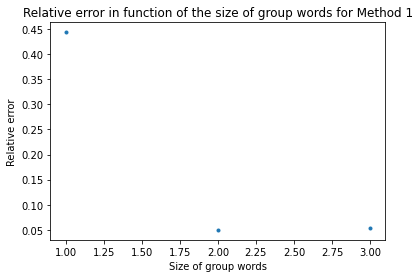

In [35]:
N1 = 3 

SpkMeansVectors_1 = [shiftGroups(i, wordResult, cutGroupWords, vectorSize) for i in range(1,N1+1)]
TimeSpkChange_1 = [indiceTime(smv, wordResult)[0] for smv in SpkMeansVectors_1]
Distances_1 = [indiceTime(smv, wordResult)[1] for smv in SpkMeansVectors_1]
Errors_1 = [errorTimeSpk(tsc, refTimeSpkChange, audio, totalTime) for tsc in TimeSpkChange_1]

plt.figure()
plt.title('Relative error in function of the size of group words for Method 1')
plt.plot(list(range(1,N1+1)), Errors_1, ".")
plt.xlabel("Size of group words")
plt.ylabel("Relative error")
plt.show()

#### Tests for cutGroupJustWords (Method 2)

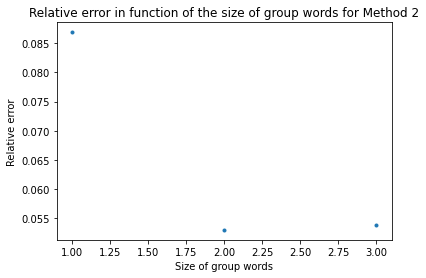

In [36]:
N2 = 3

SpkMeansVectors_2 = [shiftGroups(i, wordResult, cutGroupJustWords, vectorSize) for i in range(1,N2+1)]
TimeSpkChange_2 = [indiceTime(smv, wordResult)[0] for smv in SpkMeansVectors_2]
Distances_2 = [indiceTime(smv, wordResult)[1] for smv in SpkMeansVectors_2]
Errors_2 = [errorTimeSpk(tsc, refTimeSpkChange, audio, totalTime) for tsc in TimeSpkChange_2]

plt.figure()
plt.title('Relative error in function of the size of group words for Method 2')
plt.plot(list(range(1,N2+1)), Errors_2, ".")
plt.xlabel("Size of group words")
plt.ylabel("Relative error")
plt.show()

#### Tests for cutGroupBlankWords (Method 3)

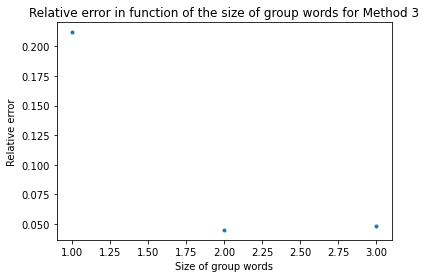

In [37]:
N3 = 3

SpkMeansVectors_3 = [shiftGroups(i, wordResult, cutGroupBlankWords, vectorSize) for i in range(1,N3+1)]
TimeSpkChange_3 = [indiceTime(smv, wordResult)[0] for smv in SpkMeansVectors_3]
Distances_3 = [indiceTime(smv, wordResult)[1] for smv in SpkMeansVectors_3]
Errors_3 = [errorTimeSpk(tsc, refTimeSpkChange, audio, totalTime) for tsc in TimeSpkChange_3]

plt.figure()
plt.title('Relative error in function of the size of group words for Method 3')
plt.plot(list(range(1,N3+1)), Errors_3, ".")
plt.xlabel("Size of group words")
plt.ylabel("Relative error")
plt.show()

#### Summary plot

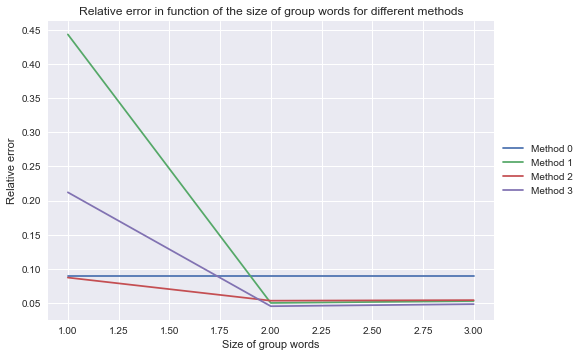

In [40]:
plt.style.use('seaborn')
plt.figure()
plt.title('Relative error in function of the size of group words for different methods')
plt.plot(list(range(1,N1+1)), [error_0]*N1, label='Method 0')
plt.plot(list(range(1,N1+1)), Errors_1, label='Method 1')
plt.plot(list(range(1,N2+1)), Errors_2, label='Method 2')
plt.plot(list(range(1,N3+1)), Errors_3, label='Method 3')
plt.xlabel("Size of group words")
plt.ylabel("Relative error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Detailed results for what seems to be the most effective method (Method 3 with group of size 2)

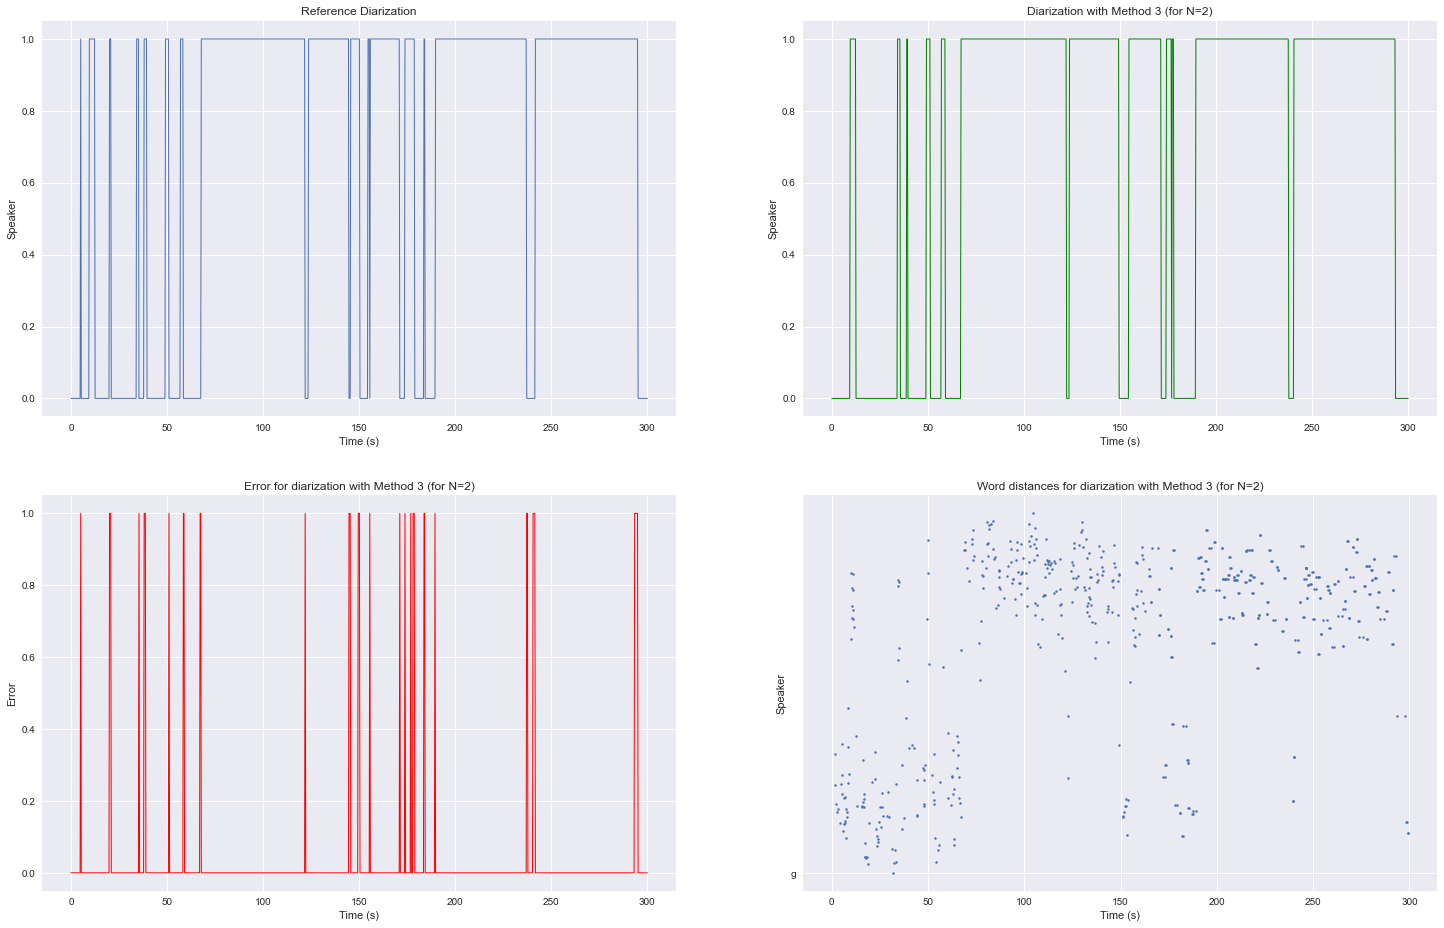

In [44]:
nTime = 1000
listTime = np.linspace(0, totalTime, nTime)

spkList = [0]
spkListRef = [0]
timeSpkChange = TimeSpkChange_3[1] # Method 3, N=2

i = 0
j = 0
for k in range(1,nTime):
    if i < len(timeSpkChange) and listTime[k] > timeSpkChange[i]:
        spkList.append(1-spkList[-1])
        i += 1
    else:
         spkList.append(spkList[-1])
    if j < len(refTimeSpkChange) and listTime[k] > refTimeSpkChange[j]:
        spkListRef.append(1-spkListRef[-1])
        j += 1
    else:
        spkListRef.append(spkListRef[-1])


fig, axs = plt.subplots(2, 2, figsize=(25,16))

axs[0,0].set_title('Reference Diarization')
axs[0,0].plot(listTime, spkListRef, linewidth=1)
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Speaker')

axs[0,1].set_title('Diarization with Method 3 (for N=2)')
axs[0,1].plot(listTime, spkList, 'green', linewidth=1)
axs[0,1].set_xlabel('Time (s)')
axs[0,1].set_ylabel('Speaker')

axs[1,0].set_title('Error for diarization with Method 3 (for N=2)')
axs[1,0].plot(listTime, [abs(spkListRef[i]-spkList[i]) for i in range(len(listTime))], 'red', linewidth=1)
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Error')

axs[1,1].set_title('Word distances for diarization with Method 3 (for N=2)')
axs[1,1].plot([(w['start'] + w['end'])/2 for w in wordResult], [1-d for d in Distances_3[1]], '.', 'g', markersize=5)
axs[1,1].set_xlabel('Time (s)')
axs[1,1].set_ylabel('Speaker')

fig.show()
